In [40]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt
%matplotlib inline

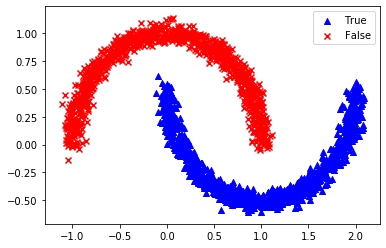

In [48]:
select_option =3  # this number controls which type of datasets selected
# 0 is linear, 1 is quardratic etc.
data_options = ['linear', 
                'quadratic', 
                'target', 
                'moons', 
                'circles', 
                'blobs']
option = data_options[select_option]

n = 2000 # number of points


X = np.random.random((n, 2))
mixing = 0 # add random mixing element to data
xplot = np.linspace(0,1, 100)
if option=='linear':
    y = np.array([False if (X[i,0]+X[i,1])>=(1.0+mixing/2-np.random.rand()*mixing) \
                    else True \
                  for i in range(n)])
    yplot = 1-xplot
elif option=='quadratic':
    y = np.array([False if X[i,0]**2>=X[i,1]+(np.random.rand()-0.5)*mixing \
                    else True \
                  for i in range(n)])
    yplot = xplot**2
elif option=='target':
    y = np.array([False if (X[i,0]-0.5)**2+(X[i,1]-0.5)**2<=0.1 +(np.random.rand()-0.5)*0.2*mixing \
                    else True \
                  for i in range(n)])
    j = False
    yplot = np.empty(100)
    for i,x in enumerate(xplot):
        r = 0.1-(x-0.5)**2
        if r<=0:
            yplot[i] = np.nan
        else:
            j = not j # plot both sides of circle
            yplot[i] = (2*j-1)*np.sqrt(r)+0.5
elif option=='moons':
    X, y = make_moons(n_samples=n,noise=0.05)
    yplot = xplot*0.0
elif option=='circles':
    X, y = make_circles(n_samples=n,noise=0.05,factor=0.5)
    yplot = xplot*0.0
elif option=='blobs':
    X, y = make_blobs(n_samples=n,centers=[[-5,3],[5,-3]],cluster_std=2.0)
    yplot = xplot*0.0

plt.scatter(X[y>0.5,0],X[y>0.5,1],color='blue',marker='^',label='True')
plt.scatter(X[y<0.5,0],X[y<0.5,1],color='red',marker='x',label='False')
if option not in ['moons','circles','blobs']:
    plt.plot(xplot,yplot,'k.',label='Division')
plt.legend()

# Split into train and test subsets (50% each)
XA, XB, yA, yB = train_test_split(X, y, test_size=0.5, shuffle=False)

# Plot regression results
def assess(P):
    plt.figure()
    plt.scatter(XB[P==1,0],XB[P==1,1],marker='^',color='blue',label='True')
    plt.scatter(XB[P==0,0],XB[P==0,1],marker='x',color='red',label='False')
    plt.scatter(XB[P!=yB,0],XB[P!=yB,1],marker='s',color='orange',alpha=0.5,label='Incorrect')
    if option not in ['moons','circles','blobs']:
        plt.plot(xplot,yplot,'k.',label='Division')
    plt.legend()

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics.pairwise import rbf_kernel
from functools import reduce
%matplotlib inline

In [50]:
# parameters
NUM_LABELS = 5
NUM_SAMPLES = 1000

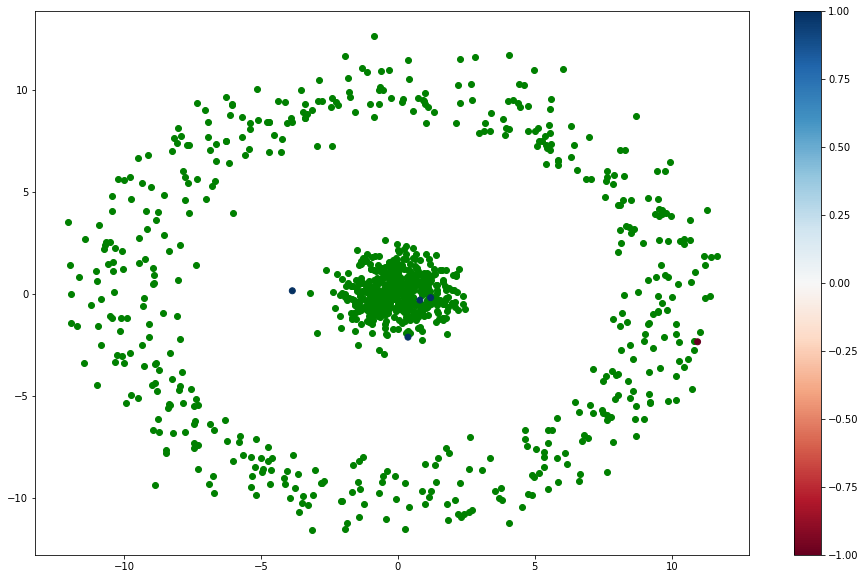

In [51]:
# synthetic datasets
X, y = make_circles(n_samples = NUM_SAMPLES, factor = 0.01, noise = 0.1, shuffle = True)
X = X * 10
y[ y == 0] = -1
y[ NUM_LABELS: ] = 0
X_labeled = X[:NUM_LABELS]
y_labeled = y[:NUM_LABELS]

X_unlabeled = X[NUM_LABELS:]
y_unlabeled = y[NUM_LABELS:]

plt.figure(figsize = (16, 10))
plt.scatter(X_unlabeled[:,0], X_unlabeled[:, 1], color='g')
#plt.scatter(X_unlabeled[:,0], X_unlabeled[:, 1], color = 'lilghtgray')

plt.scatter(X_labeled[:,0], X_labeled[:,1], c=y_labeled, cmap = 'RdBu')
plt.colorbar()

In [52]:
class RandomWalkClassifier:
    def __init__(self, gamma =1):
        self.gamma = gamma
        
    def fit(self, X, y):
        self.X_labeled = X
        self.y_labeled = y
        self.classes = np.unique(y)
    
    def predict_proba(self, X):
        # Make un-normalized submatrices
        A=rbf_kernel(X, X, gamma = self.gamma)
        for i in range(len(A)):
            A[i,i]=0
        B = rbf_kernel(X, self.X_labeled)
        
        # Normalize submatrics
        AB_row_sums = A.sum(axis =1, keepdims = True) + B.sum(axis =1, keepdims=True)
        A = A/AB_row_sums
        B = B/AB_row_sums
        I = np.eye(len(A))

        #create stationary transition sub-matrix
        M_inf = np.linalg.inv(I - A).dot(B)
        probs_df = pd.DataFrame(M_inf.T).groupby(self.y_labeled).sum().T
        probs_df = probs_df[self.classes]
        probas = probs_df.values
        return probas

    def predict(self, X):
        probas = self.predict_proba(X)
        indices = np.argmax(probas, axis=1)
        preds = np.array([self.classes[index] for index in indices])
        return preds

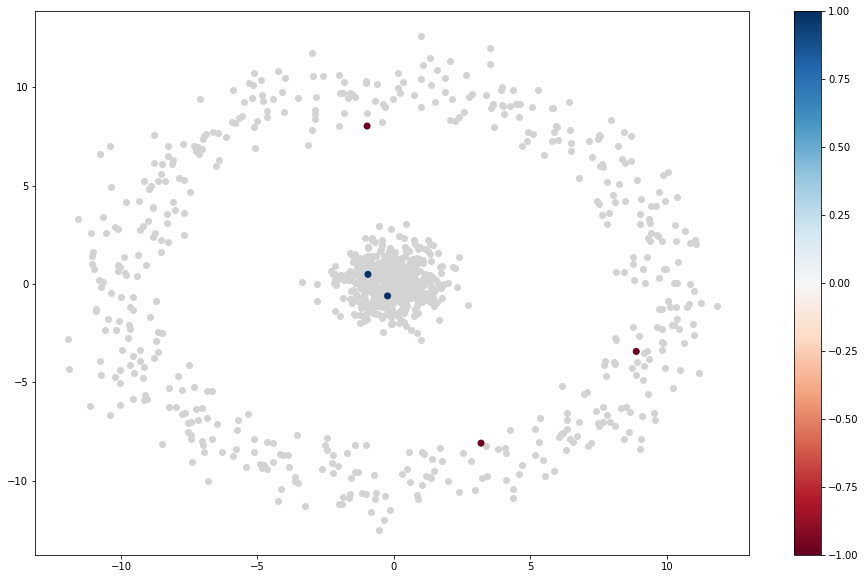

In [53]:
# synthetic datasets
X, y = make_circles(n_samples = NUM_SAMPLES, factor = 0.01, noise = 0.1, shuffle = True)
X = X * 10
y[ y == 0] = -1
y[ NUM_LABELS: ] = 0
X_labeled = X[:NUM_LABELS]
y_labeled = y[:NUM_LABELS]

X_unlabeled = X[NUM_LABELS:]
y_unlabeled = y[NUM_LABELS:]

plt.figure(figsize = (16, 10))
plt.scatter(X_unlabeled[:,0], X_unlabeled[:, 1], color='lightgray')
#plt.scatter(X_unlabeled[:,0], X_unlabeled[:, 1], color = 'lilghtgray')

plt.scatter(X_labeled[:,0], X_labeled[:,1], c=y_labeled, cmap = 'RdBu')
plt.colorbar()

Text(0.5, 1.0, 'Circles dataset, predicted labels')

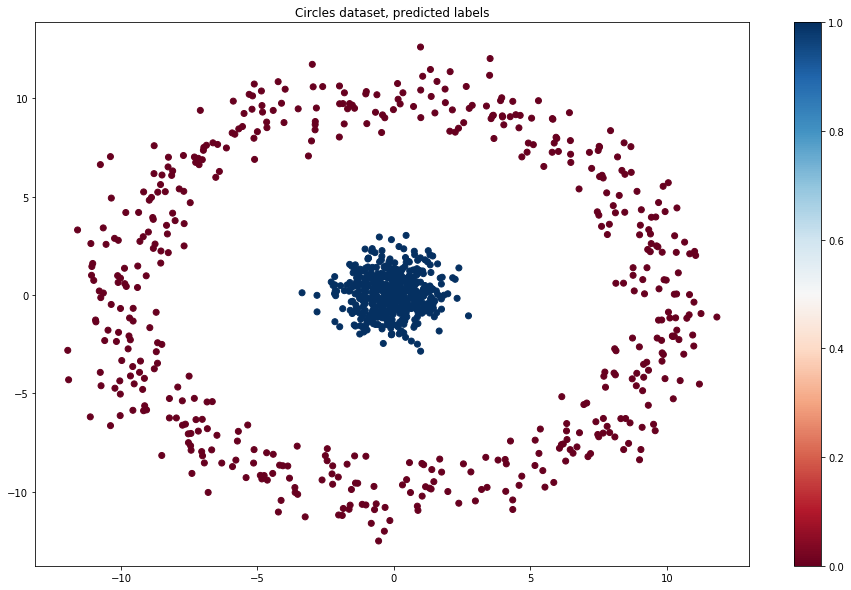

In [54]:
rwc = RandomWalkClassifier()
rwc.fit(X_labeled, y_labeled)
probas = rwc.predict_proba(X_unlabeled)

plt.figure(figsize =(16, 10))
#plt.scatter(X_unlabeled[:,0], X_unlabeled[:, 1], c=probas[:,1],cmap='RdBu')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=probas[:, 1], cmap='RdBu')

# plt.clim(0,1)
# plt.colorbar()
plt.clim(0, 1)
plt.colorbar()
plt.title('Circles dataset, predicted labels')

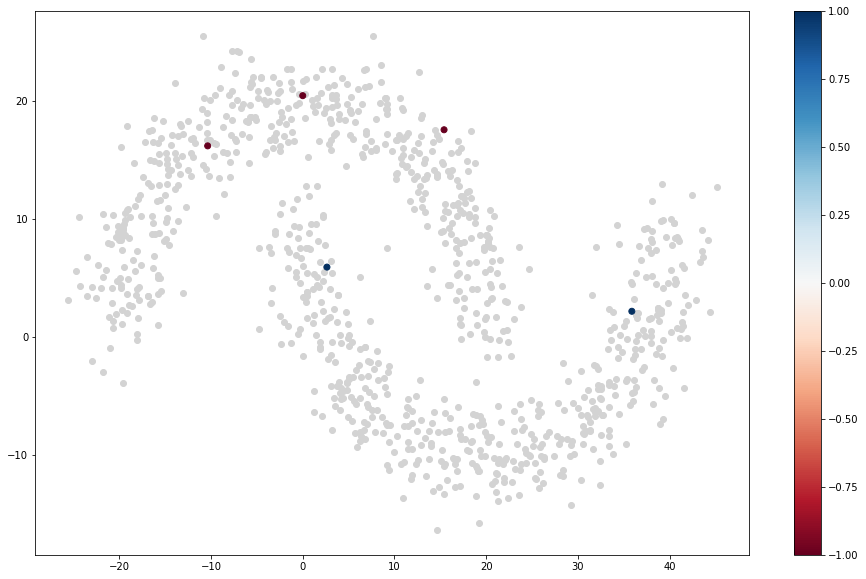

In [55]:
#NUM_SAMPLES = 1000

X, y = make_moons(n_samples = NUM_SAMPLES, noise=0.12, shuffle = True)


X = X * 20
y[ y == 0] = -1
y[ NUM_LABELS: ] = 0
X_labeled = X[:NUM_LABELS]
y_labeled = y[:NUM_LABELS]

X_unlabeled = X[NUM_LABELS:]
y_unlabeled = y[NUM_LABELS:]

plt.figure(figsize = (16, 10))
plt.scatter(X_unlabeled[:,0], X_unlabeled[:, 1], color='lightgray')
#plt.scatter(X_unlabeled[:,0], X_unlabeled[:, 1], color = 'lilghtgray')

plt.scatter(X_labeled[:,0], X_labeled[:,1], c=y_labeled, cmap = 'RdBu')
plt.colorbar()

Text(0.5, 1.0, 'Moons dataset, predicted labels')

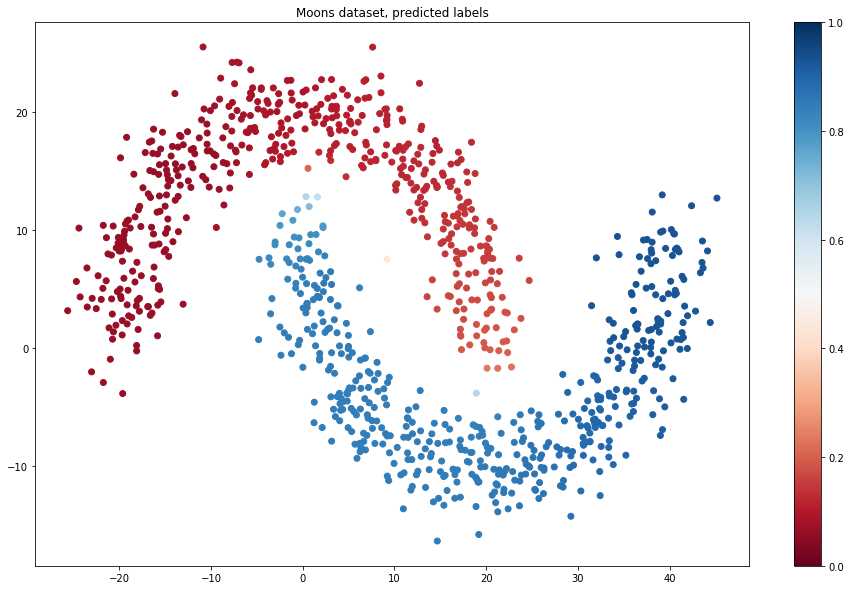

In [56]:
# gamma is the parameter that is related with the distance of the picture
rwc = RandomWalkClassifier(gamma = 0.2)
rwc.fit(X_labeled, y_labeled)
probas = rwc.predict_proba(X_unlabeled)

plt.figure(figsize = (16, 10))
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:,1], c=probas[:,1], cmap='RdBu')
plt.clim(0,1)
plt.colorbar()
plt.title('Moons dataset, predicted labels')

In [69]:
# pay attention to the way how to set index here, use location directly
five = pd.read_csv('compressor_syn.csv', index_col = 0, parse_dates = True)


In [70]:
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler = RobustScaler(quantile_range = (0.1, 0.9))
df_scaled = pd.DataFrame(scaler.fit_transform(five), columns = five.columns, index = five.index)
df_scaled.head()

,OLAP02,OLAT05,Comp_G_T11,Comp_G_P11,Comp_G_P12,Comp_G_T12,Comp_G_F10,Comp_G_F03,Comp_G_T05,Comp_G_T13,Comp_G_T14,Comp_G_T15
Timestamp,,,,,,,,,,,,
2017-06-01 01:00:00,3.772711,-0.402911,2.985782,-3.080958,4.404753,-4.706206,-3.578792,-3.905077,-4.776363,1.682008,-2.076111,-3.801523
2017-06-01 02:00:00,3.567000,-0.246284,2.598342,-3.674782,3.134932,-4.501829,-3.310403,-3.585078,-4.124018,1.728809,-2.210844,-3.445578
2017-06-01 03:00:00,2.959070,-0.416754,3.680499,-2.903957,3.328256,-4.523812,-2.753025,-2.787794,-4.434720,1.495535,-2.223912,-3.732088
2017-06-01 04:00:00,3.234208,-0.582450,3.121012,-3.732747,4.253025,-4.858137,-3.112123,-3.318693,-4.799622,1.381747,-2.389178,-4.087234
2017-06-01 05:00:00,3.550811,-0.952534,2.503741,-3.390981,3.850144,-4.391519,-3.250115,-3.488143,-4.346936,1.252887,-2.502714,-3.827212


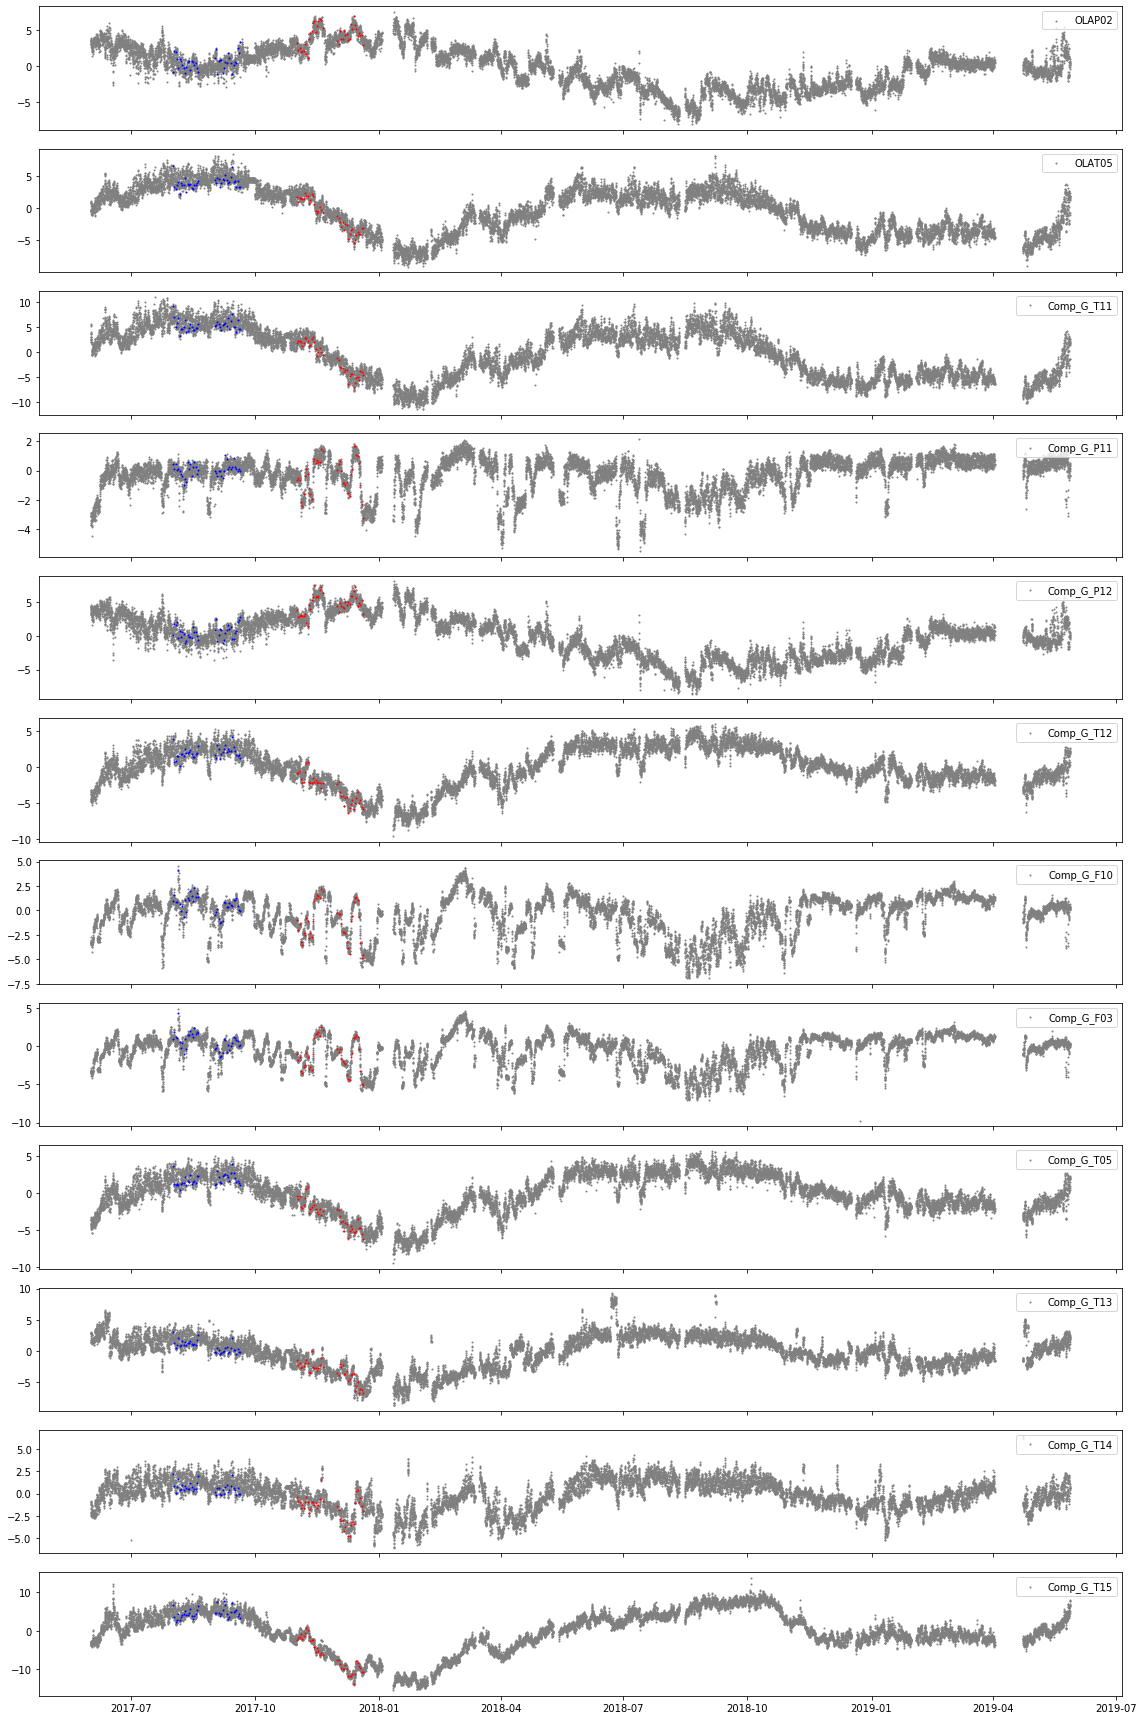

In [71]:
def plot_df(df, cols, clustering):
    nplots = len(cols)
    f, ax = plt.subplots(nplots, figsize=(16, 2*nplots), sharex=True)
    for i, c in enumerate(cols):
        ax[i].scatter(df.index, df[c], c=clustering, s=1, cmap='tab20');
        ax[i].legend([c], loc='upper right')
    plt.tight_layout()
    return f

def expand_labels(time_labels, index):
    freq = index.freq
    series_list = list()
    for time_label in time_labels:
        index_ = pd.date_range(
           start=time_label.start, end=time_label.end, freq=freq)
        series = pd.Series([time_label.label] * len(index_), index=index_)
        series_list.append(series)
    series_all = reduce(lambda x, y: x.append(y), series_list)
    series_all = series_all.reindex(index).fillna(-1)
    return series_all

def plot_df(df, time_labels, plot_unlabeled=True):
    COLORS = ['gray', 'blue', 'red', 'green']
    if not plot_unlabeled:
        COLORS = COLORS[1:]
    if isinstance(time_labels, list):
        label_series = expand_labels(time_labels, df.index)
    else:
        label_series = time_labels.sort_index()
    classes = list(sorted(label_series.unique()))
    num_plots = len(df.columns)
    fig, axes = plt.subplots(num_plots, figsize=(16, 2*num_plots), sharex=True)
    for ax, col in zip(axes, df.columns):
        for class_, color in zip(classes, COLORS):
            mask = (label_series == class_)
            ax.scatter(df.index[mask], df[col][mask], s=1, c=color);
        ax.legend([col], loc='upper right')
    plt.tight_layout()

from collections import namedtuple
TimeLabel = namedtuple('TimeLabel', 'start end label')
labels = [
    TimeLabel('2017-08-01', '2017-08-20', 0), 
    TimeLabel('2017-09-01', '2017-09-20', 0),
    TimeLabel('2017-11-01', '2017-11-20', 1),
    TimeLabel('2017-12-01', '2017-12-20', 1),

]
plot_df(df_scaled, labels)

In [ ]:
# use random walk

labels_expanded = expand_labels(labels, df_scaled.index)
mask = labels_expanded !=-1
X_labeled = df_scaled.values[mask]
y_labeled = labels_expanded.values[mask]
X_unlabeled = df_scaled.values[~mask]

rwc = RandomWalkClassifier (gamma =1)
rwc.fit(X_labeled, y_labeled)
preds =rwc.predict(X_unlabeled)

labels_expanded[~mask]=preds

plot_df(df_scaled, labels_expanded, plot_unlabeled=False)